#Importing Libraries

In [36]:
#Install packages required
!pip -qqq install gensim
!pip -qqq install git+https://www.github.com/keras-team/keras-contrib.git
!pip -qqq install --upgrade keras==2.2.4
!pip install sklearn-crfsuite
!pip -q install seqeval
!pip -q install tensorflow==1.13.0rc0

In [70]:
#Import required packages
import pandas as pd
import numpy as np
import json
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras                        import backend as K    # from tensorflow import keras as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils                  import to_categorical, plot_model
from keras.layers                 import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models                 import Model, Input
from keras_contrib.layers         import CRF
from keras.callbacks              import ModelCheckpoint
from sklearn.model_selection      import train_test_split
from sklearn_crfsuite.metrics     import flat_classification_report
from sklearn.metrics              import f1_score
from seqeval.metrics              import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text     import text_to_word_sequence


In [38]:
#Download data from Kaggle
!mkdir ~/.kaggle
token = {"username":"gugankailasam","key":"7be55bcc2396ad6d025f6b7e2b3b53b0"}

with open('kaggle.json','w') as file:
  json.dump(token,file)

!cp ./kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
import zipfile
with zipfile.ZipFile("entity-annotated-corpus.zip","r") as zip_ref:
    zip_ref.extractall("data")
!ls

mkdir: cannot create directory ‘/root/.kaggle’: File exists
entity-annotated-corpus.zip: Skipping, found more recently modified local copy (use --force to force download)
data			     kaggle.json  model.png
entity-annotated-corpus.zip  model.h5	  sample_data


In [39]:
df = pd.read_csv('/content/data/ner_dataset.csv', encoding= 'unicode_escape')#data//ner_dataset.csv
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [40]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 35231,the,NN,O
freq,1,52573,145807,887908


#Observations :

In [41]:
#Displaying the unique Tags
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [42]:
#Checking null values, if any.
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [43]:
df = df.fillna(method = 'ffill')

In [44]:
# This is a class that get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [45]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [46]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [47]:
sentences = getter.sentences
print(sentences)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#Defining the parameters for LSTM network

In [48]:
# Number of data points passed in each iteration
batch_size = 64 
# Passes through entire dataset
epochs = 3
# Maximum length of review
max_len = 75 
# Dimension of embedding vector
embedding = 40

#Preprocessing Data

In [49]:
#Getting unique words and labels from data
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [50]:
print("The word India is identified by the index: {}".format(word_to_index["India"]))
print("The label B-org for the organization is identified by the index: {}".format(tag_to_index["B-org"]))

The word India is identified by the index: 2570
The label B-org for the organization is identified by the index: 6


In [51]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [52]:
# Convert label to index
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [53]:
num_tag = df['Tag'].nunique()
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [54]:
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [55]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (40765, 75)
Size of training output data :  (40765, 75, 18)
Size of testing input data :  (7194, 75)
Size of testing output data :  (7194, 75, 18)


In [56]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 11 17  3 18 19 20 21 22 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [57]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[2] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


#Bidirectional LSTM-CRF Network

In [58]:
num_tags = df['Tag'].nunique()
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf   = CRF(num_tags+1)  # CRF layer
out   = crf(model)       # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 75, 40)            1407200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 75, 18)            1278      
Total params: 1,449,928
Trainable params: 1,449,928
Non-trainable params: 0
_________________________________________________________________


In [59]:
#Plotting the model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [60]:
checkpointer = ModelCheckpoint(filepath = 'model.h5', verbose = 0, mode = 'auto', save_best_only = True, monitor='val_loss')

In [61]:
#Training the model
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs, 
                    validation_split=0.1, callbacks=[checkpointer])

Train on 36688 samples, validate on 4077 samples
Epoch 1/3
36688/36688 [==============================] - 155s 4ms/step - loss: 9.1579 - crf_viterbi_accuracy: 0.8904 - val_loss: 8.8344 - val_crf_viterbi_accuracy: 0.9437
Epoch 2/3
36688/36688 [==============================] - 153s 4ms/step - loss: 8.8745 - crf_viterbi_accuracy: 0.9573 - val_loss: 8.7652 - val_crf_viterbi_accuracy: 0.9608
Epoch 3/3
36688/36688 [==============================] - 151s 4ms/step - loss: 8.8331 - crf_viterbi_accuracy: 0.9679 - val_loss: 8.7426 - val_crf_viterbi_accuracy: 0.9657


In [62]:
#history gives loss parameter to analyse
history.history.keys()

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

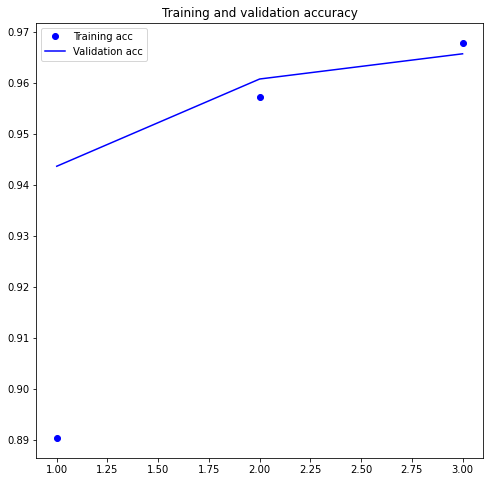

In [63]:
#Plotting Training and validation accuracy
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

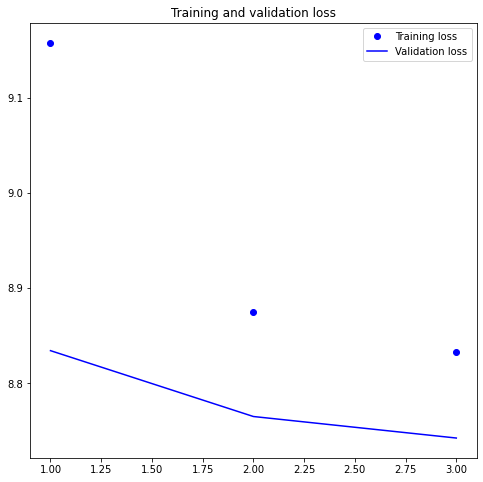

In [64]:
#Plotting Training and validation loss
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#Evaluating the model on test set

In [65]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [66]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [67]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 87.4%


In [68]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        66
       B-eve       0.00      0.00      0.00        35
       B-geo       0.87      0.87      0.87      5698
       B-gpe       0.97      0.91      0.94      2289
       B-nat       0.00      0.00      0.00        28
       B-org       0.80      0.67      0.73      2918
       B-per       0.75      0.85      0.80      2439
       B-tim       0.90      0.85      0.87      2934
       I-art       0.00      0.00      0.00        41
       I-eve       0.00      0.00      0.00        27
       I-geo       0.81      0.75      0.78      1154
       I-gpe       1.00      0.55      0.71        31
       I-nat       0.00      0.00      0.00         5
       I-org       0.80      0.76      0.78      2536
       I-per       0.82      0.90      0.86      2437
       I-tim       0.86      0.65      0.74       964
           O       0.99      0.99      0.99    132245
         PAD       1.00    

In [69]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_test)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))

# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 3615 of 7194 (Test Set)
Word           ||True ||Pred
Iranian        : B-gpe B-gpe
officials      : O     O
then           : O     O
confirmed      : O     O
the            : O     O
31-year-old    : O     O
journalist     : O     O
is             : O     O
being          : O     O
held           : O     O
in             : O     O
Tehran         : B-geo B-geo
's             : O     O
infamous       : O     O
Evin           : B-tim O
prison         : O     O
,              : O     O
saying         : O     O
that           : O     O
she            : O     O
worked         : O     O
illegally      : O     O
in             : O     O
the            : O     O
country        : O     O
after          : O     O
her            : O     O
press          : O     O
credentials    : O     O
had            : O     O
been           : O     O
revoked        : O     O
.              : O     O
